In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Attention, GlobalMaxPooling1D,LayerNormalization
)
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.regularizers import l2

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stopwords_list=stopwords.words("english")
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
df=pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding="Latin-1")

In [6]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
df.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [8]:
df.rename(columns={'0':"sentiment","""@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D""":"text"},inplace=True)

In [9]:
# sentiment_dataset=df[["text","sentiment"]]

In [10]:
# sentiment_dataset.head()

In [11]:
def remove_unnecessery_caracter(text):
  text=re.sub(r"<.*?>","",str(text))
  text=re.sub(r"[^a-zA-Z0-9\s]","",str(text))
  text=re.sub(r"\s+"," ",str(text)).strip()
  return text

In [12]:
df["text"]=df["text"].apply(remove_unnecessery_caracter)

In [13]:
def tokenizer(text):
  try :
    text=str(text)
    text=word_tokenize(text)
    return text
  except Exception as e:
    print("error tokenizer" ,e)
    return []

In [14]:
df["text"]=df["text"].apply(tokenizer)

In [15]:
def text_normalization(text):
  text=[str(w).lower() for w in text ]
  return text

In [16]:
df["text"]=df["text"].apply(text_normalization)

In [17]:
df["text"].iloc[0]

['is',
 'upset',
 'that',
 'he',
 'cant',
 'update',
 'his',
 'facebook',
 'by',
 'texting',
 'it',
 'and',
 'might',
 'cry',
 'as',
 'a',
 'result',
 'school',
 'today',
 'also',
 'blah']

<Axes: xlabel='sentiment'>

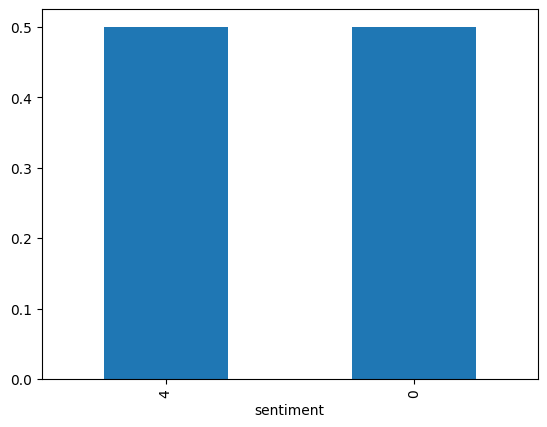

In [18]:
df["sentiment"].value_counts(normalize=True).plot(kind="bar")

In [19]:
max_sequence_lenght=len(df["text"].sort_values(key=lambda x : x.apply(len),ascending=False).iloc[0])
max_sequence_lenght

41

In [20]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-28 13:09:13--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-28 13:09:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 38s  

2024-11-28 13:11:52 (5.19 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [21]:
!unzip /kaggle/working/glove.6B.zip -d glove-embedding

Archive:  /kaggle/working/glove.6B.zip
  inflating: glove-embedding/glove.6B.50d.txt  
  inflating: glove-embedding/glove.6B.100d.txt  
  inflating: glove-embedding/glove.6B.200d.txt  
  inflating: glove-embedding/glove.6B.300d.txt  


In [22]:
words_embedding={}
with open("/kaggle/working/glove-embedding/glove.6B.50d.txt") as f :
  for line in f :
    values =line.split()
    word=values[0]
    embedding=np.asarray(values[1:], dtype='float32')
    words_embedding[word]=embedding

In [23]:
words_embedding["out_voc"]=np.zeros((50,))

In [24]:
def expend_dim(text):
  add_seq=max_sequence_lenght-len(text)
  for _ in range(add_seq):
    text.append("out_voc")
  return text

In [25]:
df["text"]=df["text"].apply(expend_dim)

In [26]:
all_words=[]
for i in df.itertuples():
  all_words+=i.text

In [27]:
vocab=set(all_words)

In [28]:
word_to_index={w:i for i,w in enumerate(vocab)}

In [29]:
word_to_index["is"]

480480

In [30]:
vocab_size=len(set(all_words))
embedding_dim=len(words_embedding.get("the"))

In [31]:
vocab_size

839895

In [32]:
embedding_matrix=np.zeros((vocab_size,embedding_dim))
for w ,i in word_to_index.items():
  if i <vocab_size:
    vec=words_embedding.get(w,None)
    if vec is not None :
      embedding_matrix[i]=vec

In [33]:
print(embedding_matrix.shape)
embedding_matrix

(839895, 50)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
def index_map(text):
  out_ov_index=word_to_index.get("out_voc")
  text=[word_to_index.get(w,out_ov_index) for w in text if w in text ]
  return text

In [35]:
df["text"]=df["text"].apply(index_map)

In [36]:
df["text"]

0          [480480, 2436, 525732, 379989, 245269, 317618,...
1          [657846, 44935, 219137, 476290, 820891, 60356,...
2          [530341, 652823, 682789, 215899, 34909, 711092...
3          [32924, 534455, 812063, 152637, 468145, 825966...
4          [236559, 152637, 424964, 652823, 733512, 54605...
                                 ...                        
1599994    [356070, 596678, 124012, 277305, 534455, 52752...
1599995    [26265, 671524, 553395, 389334, 646087, 640701...
1599996    [29025, 702467, 352852, 60356, 374690, 357289,...
1599997    [597590, 552712, 425356, 389334, 530341, 26466...
1599998    [597590, 492611, 259978, 326195, 625073, 54605...
Name: text, Length: 1599999, dtype: object

In [37]:
y=df["sentiment"]
x=df["text"]
y_reshaped=y.to_frame()

In [38]:
x_reshaped=np.concatenate(x).reshape((-1,max_sequence_lenght))

In [39]:
ohe=OneHotEncoder(sparse_output=False)
transformed_y=ohe.fit_transform(y_reshaped)
transformed_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [40]:
transformed_y.shape

(1599999, 2)

## test dataset 

In [41]:
x_train,x_test,y_train,y_test=train_test_split(x_reshaped,transformed_y,test_size=0.2,shuffle=True)

In [42]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1279999, 41)
(320000, 41)
(1279999, 2)
(320000, 2)


In [43]:

# max_length = max_sequence_lenght
# lstm_units = 256

# # Input Layer
# input_layer = Input(shape=(max_length,), name="Input")

# # Embedding Layer
# embedding_layer = tf.keras.layers.Embedding(
#     input_dim=vocab_size,
#     output_dim=embedding_dim,
#     weights=[embedding_matrix],
#     trainable=False,
#     name="embedding"

# )(input_layer)

# # BiLSTM Layer
# bilstm_layer = Bidirectional(LSTM(units=lstm_units,
#                                   return_sequences=True,
#                                   dropout=0.2,
#                                   ),
#                              name="BiLSTM")(embedding_layer)

# # Attention Mechanism
# attention_weights = Dense(256, activation='relu')(bilstm_layer)
# attention_weights = Dense(1, activation='tanh')(attention_weights)
# attention_weights = tf.keras.layers.Flatten()(attention_weights)
# attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)
# attention_output = tf.keras.layers.Dot(axes=1)([attention_weights, bilstm_layer])

# # Fully Connected Layers
# dense_1 = Dense(256, activation='relu', name="Dense_1")(attention_output)
# normalized_output = LayerNormalization(name="Batchnorm")(dense_1)
# dense_2 = Dense(128, activation='relu', name="Dense_2")(normalized_output)
# dropout_2 = Dropout(0.2, name="Dropout_2")(dense_2)

# # Output Layer
# output_layer = Dense(3, activation='softmax', name="Output")(dropout_2)

# # Model
# model = Model(inputs=input_layer, outputs=output_layer, name="Sentiment_Analysis_Model")

# # Compile Model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Summary
# model.summary()

In [44]:
# Input Layer
input_layer = Input(shape=(max_sequence_lenght,), name="Input")

# Embedding Layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
    name="embedding")(input_layer)

# LSTM with return_sequences=True to work with attention
x = LSTM(units=256, return_sequences=True)(embedding_layer)

# Attention Mechanism
attention_weights = Dense(256, activation='relu')(x)
attention_weights = Dense(1, activation='tanh')(attention_weights)
attention_weights = tf.keras.layers.Softmax(axis=1)(attention_weights)
context_vector = tf.keras.layers.Dot(axes=1)([attention_weights, x])

# Subsequent layers
x = LSTM(units=128, return_sequences=False)(context_vector)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(units=2, activation="softmax")(x)

lstm_model = Model(inputs=input_layer, outputs=output)
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
lstm_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 41)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 41, 50)    │ 41,994,750 │ Input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 41, 256)   │    314,368 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 41, 256)   │     65,792 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 41, 1)     │        257 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 41, 1)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 256)    │          0 │ softmax[0][0],    │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    197,120 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,589,057 (162.46 MB)

 Trainable params: 594,307 (2.27 MB)

 Non-trainable params: 41,994,750 (160.20 MB)

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history =lstm_model.fit(x_train,y_train,validation_data=(x_test, y_test),batch_size=32,epochs=20,callbacks=[early_stopping])

Epoch 1/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 329s 8ms/step - accuracy: 0.7554 - loss: 0.4953 - val_accuracy: 0.8100 - val_loss: 0.4153
Epoch 2/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 325s 8ms/step - accuracy: 0.8169 - loss: 0.4020 - val_accuracy: 0.8178 - val_loss: 0.3996
Epoch 3/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 326s 8ms/step - accuracy: 0.8300 - loss: 0.3777 - val_accuracy: 0.8193 - val_loss: 0.3974
Epoch 4/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 325s 8ms/step - accuracy: 0.8386 - loss: 0.3620 - val_accuracy: 0.8188 - val_loss: 0.3986
Epoch 5/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 325s 8ms/step - accuracy: 0.8455 - loss: 0.3488 - val_accuracy: 0.8170 - val_loss: 0.4033
Epoch 6/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 325s 8ms/step - accuracy: 0.8496 - loss: 0.3402 - val_accuracy: 0.8192 - val_loss: 0.4055
Epoch 7/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 325s 8ms/step - accuracy: 0.8534 - loss: 0.3331 - val_accuracy: 0.8183 - val_loss: 0.4040
Epoch 8/20
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 325s 8ms/step - ac

In [46]:
lstm_model.evaluate(x_test,y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8201 - loss: 0.3971


[0.3973987400531769, 0.8193125128746033]

In [ ]:
mapper={4:"positive",0:"negative"}
def pipline(text):
    text=remove_unnecessery_caracter(text)
    text=tokenizer(text)
    text=text_normalization(text)
    text=expend_dim(text)
    text=index_map(text)
    text=np.expand_dims(text,0)
    prediction=lstm_model.predict(text)
    ohe_prediction=np.zeros((1,prediction.shape[-1]))
    ohe_prediction[0,np.argmax(prediction)]=1
    mood =ohe.inverse_transform(prediction)
    result=mapper[mood]
    return result
    
    
    
    

In [ ]:
pipline("Absolutely love it! Worth every penny. I’ll definitely buy it again")

In [49]:
pipline('This product exceeded my expectations! High-quality and works perfectly')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


4

In [50]:
pipline(" The staff was incredibly helpful and went above and beyond to assist me.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


4

In [51]:
pipline("This product is a complete waste of money. It broke after just one use, and the quality is horrible")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


0

In [52]:
pipline("The item arrived late and was defective. Customer support was no help at all")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


0